In [1]:
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [96]:
#!pip install opencv-python

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import shutil
import imghdr

from glob import glob

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
training_path = '/content/drive/MyDrive/projects/Brain_Tumor_Classification/Images_Brain/Training'
testing_path = '/content/drive/MyDrive/projects/Brain_Tumor_Classification/Images_Brain/Testing'

In [6]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [7]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [8]:
import tensorflow as tf
tf.test.gpu_device_name()

''

We can see from the above output that Tensorflow is using the NVIDIA Tesla T4 GPU.

In [9]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [10]:
!ls /content/drive/MyDrive/projects/Brain_Tumor_Classification/Images_Brain

Testing  Training


In [17]:
os.listdir(training_path)

['glioma_tumor', 'pituitary_tumor', 'no_tumor', 'meningioma_tumor']

In [18]:
os.listdir(os.path.join(training_path,'pituitary_tumor'))[0:5]

['p (221).jpg', 'p (161).jpg', 'p (401).jpg', 'p (420).jpg', 'p (203).jpg']

In [19]:
for image_class in os.listdir(training_path):
  print(image_class)


glioma_tumor
pituitary_tumor
no_tumor
meningioma_tumor


In [20]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [21]:
img = cv2.imread(os.path.join(training_path, 'pituitary_tumor', 'p (503).jpg'))

In [22]:
img.shape

(512, 512, 3)

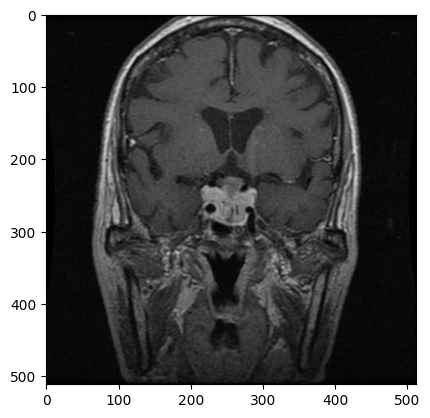

In [23]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB ))
plt.show()

In [24]:
for image_class in os.listdir(training_path):
  for image in os.listdir(os.path.join(training_path, image_class)):
    image_path = os.path.join(training_path, image_class, image)
    try:
        img = cv2.imread(image_path)
        tip = imghdr.what(image_path)
        if tip not in image_exts:
            print('Image not in ext list {}'.format(image_path))
            os.remove(image_path)
    except Exception as e:
        print('Issue with image {}'.format(image_path))
        # os.remove(image_path)

In [25]:
for image_class in os.listdir(testing_path):
  for image in os.listdir(os.path.join(testing_path, image_class)):
    image_path = os.path.join(testing_path, image_class, image)
    try:
        img = cv2.imread(image_path)
        tip = imghdr.what(image_path)
        if tip not in image_exts:
            print('Image not in ext list {}'.format(image_path))
            os.remove(image_path)
    except Exception as e:
        print('Issue with image {}'.format(image_path))
        # os.remove(image_path)

# Loading data

Thr datset was already split into testing and training data so we do not need to define these later

In [86]:
# Load the training dataset
Training_data = tf.keras.utils.image_dataset_from_directory(
    training_path,
    labels='inferred',  # Automatically infer labels from the directory structure
    image_size=(256, 256),  # Adjust as needed
    batch_size=32,  # Adjust as needed
    validation_split=0.2,  # Split 20% of the data for validation
    subset='training',  # Specify it's the training set
    seed=42  # Optional: Set a seed for reproducibility
)

# Load the validation dataset
Validation_data = tf.keras.utils.image_dataset_from_directory(
    training_path,
    labels='inferred',
    image_size=(256, 256),
    batch_size=32,
    validation_split=0.2,
    subset='validation',  # Specify it's the validation set
    seed=42
)

# Load the testing dataset
Testing_data = tf.keras.utils.image_dataset_from_directory(
    testing_path,
    labels='inferred',
    image_size=(256, 256),
    batch_size=32,
)

Found 2910 files belonging to 4 classes.
Using 2328 files for training.
Found 2910 files belonging to 4 classes.
Using 582 files for validation.
Found 394 files belonging to 4 classes.


In [87]:
Training_iterator = Training_data.as_numpy_iterator()
Testing_iterator = Testing_data.as_numpy_iterator()


In [88]:
Training_iterator

In [89]:
batch_training = Training_iterator.next()
batch_testing = Testing_iterator.next()

In [90]:
len(batch_training)

2

len of 2 as the image is 1 dimension and the label is the  other

In [91]:
batch_training[0].shape

(32, 256, 256, 3)

In [92]:
batch_training[1]

array([1, 0, 3, 0, 0, 3, 1, 3, 3, 1, 0, 3, 2, 0, 1, 3, 0, 0, 3, 1, 3, 2,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 3], dtype=int32)

In [94]:
# Inspect class names
class_names = Training_data.class_names
print("Class Names:", class_names)

Class Names: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


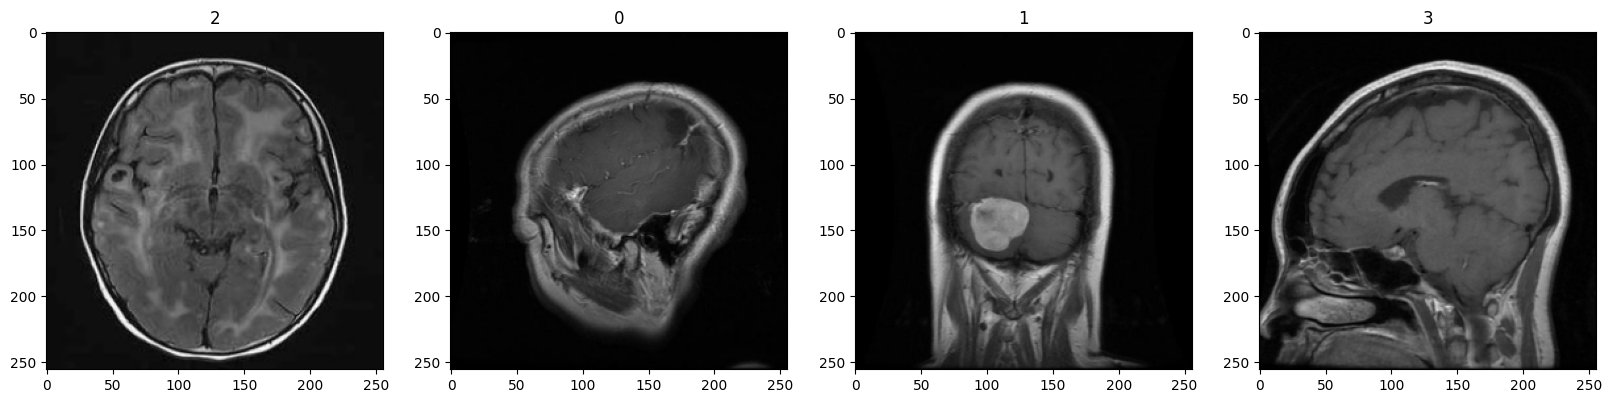

In [93]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img_index in enumerate([12,13,14,15]):
    ax[idx].imshow(batch_training[0][img_index].astype(int))
    ax[idx].title.set_text(batch_training[1][img_index])


#### Labels
-   0 : Glioma Tumor
-   1 : Meningioma Tumor
-   2 : No Tumor
-   3 : Pituitary Tumor


# Preprocessing Data

In [36]:
Training_data = Training_data.map(lambda x, y: (x/255, y))
Testing_data = Testing_data.map(lambda x, y: (x/255, y))
# X is Images
# Y is Labels


In [58]:
Training_data

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [65]:
batch_training = Training_data.as_numpy_iterator().next()
batch_testing = Testing_data.as_numpy_iterator().next()
# #batch_training[0].max()
#Testing_data.as_numpy_iterator().next()

Training_data.as_numpy_iterator().next()[0][0]
Testing_data.as_numpy_iterator().next()[0][0]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

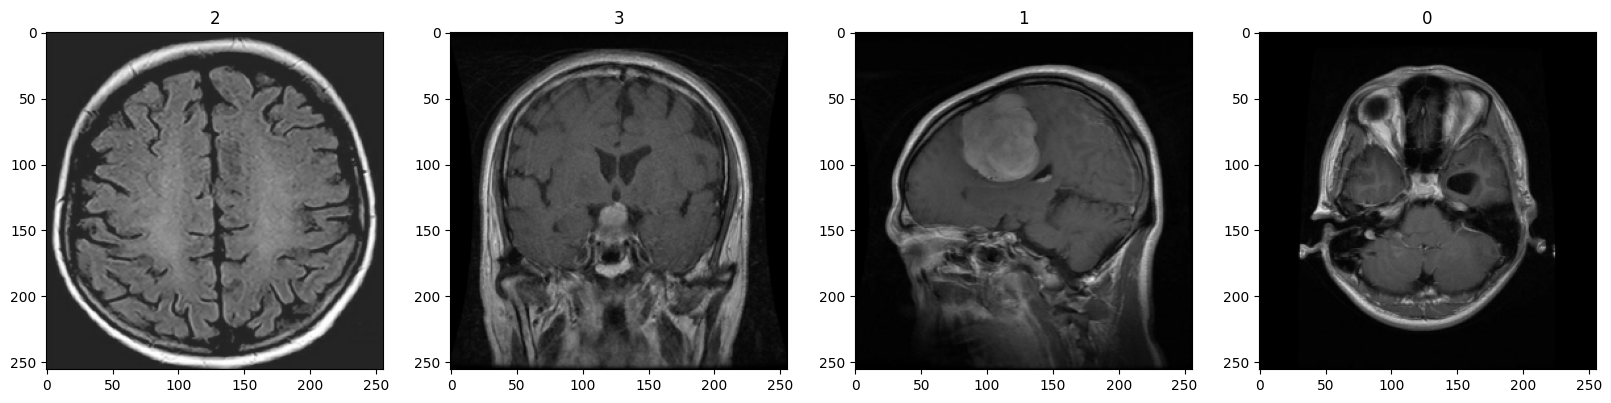

In [66]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img_index in enumerate([0,1,2,3]):
    ax[idx].imshow(batch_training[0][img_index])
    ax[idx].title.set_text(batch_training[1][img_index])


# Deep Model

In [39]:
# google how to use dropout


In [68]:
model = Sequential()

# First have an input layer, going to have 16 filters, filter is a 3x3, stride of 1
# Relu activation turns negative values to 0, and preserves positive values
model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(4, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten()) # condense values

# Fully connected layers
model.add(Dense(256, activation = 'relu'))

# Final layer that gives a single output and represets the label
model.add(Dense(4, activation = 'softmax'))

In [69]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [70]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 4)         1156      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 30, 30, 4)        

#### Training

In [71]:
logdir = '/content/drive/MyDrive/projects/Brain_Tumor_Classification/logs'

In [72]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [73]:
hist = model.fit(Training_data, epochs = 20, callbacks = [tensorboard_callback])

Epoch 1/20


ValueError: ignored